In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from hyperimpute.plugins.utils.simulate import simulate_nan


def gen_data(df: pd.DataFrame, ratio: float, seed: int = None):
    if seed:
        np.random.seed(seed)   
    vals = df.values
    MAR_result = simulate_nan(vals, ratio, mecha="MAR", p_obs=0.0, sample_columns=False)
    MCAR_result = simulate_nan(vals, ratio, mecha="MCAR")
    MNAR_result = simulate_nan(vals, ratio, mecha="MNAR", opt="logistic")
    MAR_mask = MAR_result["mask"].astype(bool)
    MCAR_mask = MCAR_result["mask"].astype(bool)
    MNAR_mask = MNAR_result["mask"].astype(bool)
    return MAR_mask[:,1:], MCAR_mask[:,1:], MNAR_mask[:,1:]


def get_points(mask):
    points = []
    n, m = mask.shape
    box_size = max(n, m)
    v_repeat = math.ceil(box_size / n)
    h_repeat = math.ceil(box_size / m)
    box  = np.tile(mask, (v_repeat, h_repeat))
    box = box[:box_size, :box_size]

    for i in range(box_size):
        for j in range(box_size):
            if box[i, j]:
                points.append([i, j])
    points = np.array(points)
    return points, box_size

def cal_dis(points, box_size):
    dis = []
    n = points.shape[0]
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            posi = points[i]
            posj = points[j]
            dr = posj - posi
            dr = dr - box_size * np.floor(dr / box_size + 0.5)

            dist = np.sqrt(np.sum(dr**2))
            dis.append(dist)
    return np.array(dis)

def cal_dis_vec(points, box_size):
    points = np.asarray(points, dtype=np.float16)
    box_size = np.float16(box_size)
    
    n = points.shape[0]
    
    # Calculate all pairwise differences
    diff = points[np.newaxis, :, :] - points[:, np.newaxis, :]
    
    # Apply minimum image convention
    diff -= box_size * np.floor(diff / box_size + 0.5)
    
    # Calculate distances
    dist = np.sqrt(np.sum(diff**2, axis=-1))
    
    # Get upper triangular indices excluding diagonal
    i_upper, j_upper = np.triu_indices(n, k=1)
    upper_triangular = dist[i_upper, j_upper]
    
    # Get lower triangular indices excluding diagonal
    i_lower, j_lower = np.tril_indices(n, k=-1)
    lower_triangular = dist[i_lower, j_lower]

    all_distances = np.concatenate((upper_triangular, lower_triangular))

    return all_distances


def hist_dis(dists, max_dist, bin_size):
    bins = np.arange(0, max_dist + bin_size, bin_size)
    hist, bin_edge = np.histogram(dists,bins=bins)
    return hist, bin_edge

def plot_hist(hist, bin_edge):
    bin_center = (bin_edge[:-1] + bin_edge[1:]) / 2.0
    plt.plot(bin_center, hist, marker="o")
    plt.xlabel("$r$")
    plt.ylabel("N(r)")
    plt.show()

def plot_rdf(gofr, bin_center, save=False, save_path=None):
    plt.plot(bin_center, gofr, marker="o")
    plt.xlabel("$r$")
    plt.ylabel("g(r)")
    if save and save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()

def get_gofr(hist,bin_edges,num_particles, box_size):
    rho = num_particles/ box_size / box_size
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2.0
    dr = bin_edges[1]-bin_edges[0]
    denominator = 2.*np.pi*bin_centers*dr*rho*num_particles
    gofr = hist/denominator
    
    return gofr, bin_centers

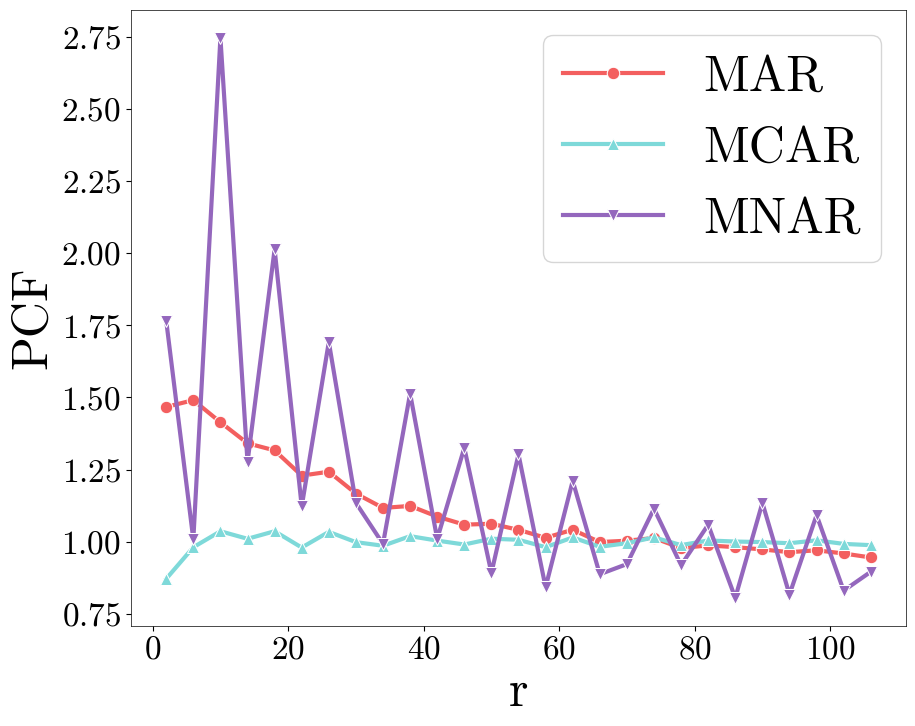

In [1]:
import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt
import numpy as np

plt.style.use(['nature', 'no-latex'])

avg_gofr_MAR, avg_gofr_MCAR, avg_gofr_MNAR, bin_centers = np.load("./3types-rdf-glass.npy", allow_pickle=True)


fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(x=bin_centers, y=avg_gofr_MAR, ax=ax, color="#F35F5F", marker="o", label="MAR",markersize=9,linewidth=3)
sns.lineplot(x=bin_centers, y=avg_gofr_MCAR, ax=ax, color="#7ED9D9", marker="^", label="MCAR",markersize=9,linewidth=3)
sns.lineplot(x=bin_centers, y=avg_gofr_MNAR, ax=ax, color="#9467BD", marker="v", label="MNAR",markersize=9,linewidth=3)
ax.legend(fontsize=36)
ax.set_xlabel("r",fontsize=36)
ax.set_ylabel("PCF",fontsize=36)
ax.tick_params(labelsize=24)

plt.savefig("results/3types-rdf-glass.png", dpi=300)
plt.show()

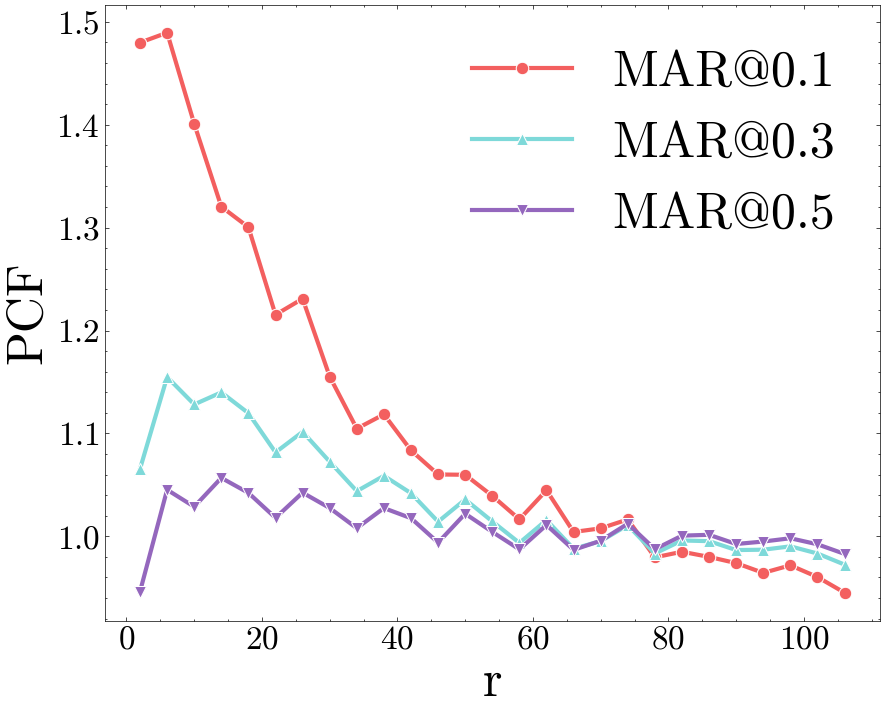

In [2]:
import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt
import numpy as np

plt.style.use(['science', 'no-latex'])

avg_gofr_01, avg_gofr_03, avg_gofr_05, bin_centers = np.load("./3ratios-rdf-glass.npy", allow_pickle=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(x=bin_centers, y=avg_gofr_01, ax=ax, color="#F35F5F", marker="o", label="MAR@0.1",markersize=9,linewidth=3)
sns.lineplot(x=bin_centers, y=avg_gofr_03, ax=ax, color="#7ED9D9", marker="^", label="MAR@0.3",markersize=9,linewidth=3)
sns.lineplot(x=bin_centers, y=avg_gofr_05, ax=ax, color="#9467BD", marker="v", label="MAR@0.5",markersize=9,linewidth=3)
ax.legend(fontsize=36)
ax.set_xlabel("r",fontsize=36)
ax.set_ylabel("PCF",fontsize=36)
ax.tick_params(labelsize=24)

plt.savefig("results/ratio-rdf-glass.png", dpi=300)
plt.show()